# LCPB 20-21 exercise 3

### Saverio Monaco

### Gerardo Carmona

### Hilario Capettini

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras import initializers,regularizers

In [2]:
def data_import(str0):
    fnamex ="DATA/x_" + str0 + ".csv"
    fnamey ="DATA/y_" + str0 + ".csv"

    x = np.loadtxt(fnamex,delimiter=',',dtype=float)
    N = len(x)
    print('Length of x = ',N)



    categ = np.loadtxt(fnamey,delimiter=',', dtype=int)
    #Number of categories
    N_categ = len(np.unique(categ))
    y = np.zeros((N,N_categ))

    for n in range(N):
        y[n][categ[n]] = 1
     
    
    return x,y,N
    

def set_spliting(N,x,y,perc_train = 0.8):  
    N_train = int(N * perc_train)
    N_val = N-N_train

    x_train = x[:N_train]
    y_train = y[:N_train]

    x_val = x[N_train:]
    y_val = y[N_train:]
    
    L =len(x[0])
    
    
    x_train = x_train.reshape(x_train.shape[0],L,1)
    x_val = x_val.reshape(x_val.shape[0],L,1)
    input_shape = (L,1)

    return x_train, y_train, x_val, y_val, input_shape
    
def data_process(x,N):
    xm = x.mean(axis=1)
    for n in range(N):
        x[n] = x[n]-xm[n]
    
    std = x.std(axis=1)
    for n in range(N):
        x[n] = x[n] / std[n]
    return x

def build_model(first_layer,deep_layers,output_size,output_activation = 'softmax', opt = optimizers.Adam()):
    model = Sequential()
    model.add(first_layer)
    for layer in layers: model.add(layer)
    model.add(Dense(output_size,activation = output_activation))
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

    return model


In [3]:
def plot_confusionmatrix(y_pred, y_true, normalization = False):
    # Insted of having y = [0,0,1] , [0,1,0] and [1,0,0] as labels, we transform them in
    # y = 0, 1 ,2
    y_true_mod = np.argmax(y_true, axis=1) #tells wich of the 3 argument is max
    # same for the prediction
    y_pred_mod = np.argmax(y_pred, axis=1)
    # N.B: if we don't do that we get the following error: 
    # ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets
    conf_mat = confusion_matrix(y_pred_mod, y_true_mod) # doing the same makes sense, we take the argument
                                                        # with the highest value (i.e more probable)
    if normalization:
        norm = np.sum(np.sum(conf_mat,axis=1))
        conf_mat = conf_mat / norm
        #print(norm)
        # check that it is normalized
        #print(np.sum(np.sum(conf_mat,axis=0)))
    fig, ax = plt.subplots(figsize=(10,10))
    if not normalization:
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap = "mako")
    if normalization:
        sns.heatmap(conf_mat, annot=True, fmt='f', cmap = "mako")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_accuracyloss(fit):
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    axs = [ax1,ax2]
    obs = ['accuracy','loss']
    for i in range(2):
        axs[i].plot(fit.history[obs[i]],'r',label =obs[i]+' of training data')
        #dashed line!!
        axs[i].plot(fit.history['val_'+obs[i]],'b--',
            label =obs[i]+' of validation data')
        axs[i].set_ylabel(obs[i])
        axs[i].set_xlabel('epochs')
        axs[i].legend()

In [4]:
#File importation
str0="ts_L60_Z12_A500_DX50_bias5_N10000"
x, y, N = data_import(str0)
x = data_process(x,N)
x_train, y_train, x_val, y_val, input_shape = set_spliting(N,x,y)

Length of x =  10000


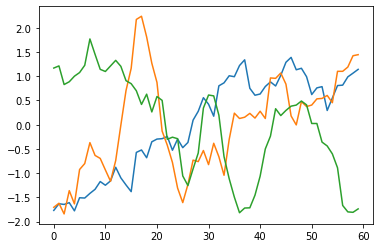

In [5]:
#Data visualization
plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

In [6]:
reg = regularizers.l1(0.01)    
#Now we initialize the NN weights
ini = initializers.RandomNormal(mean=0,stddev=0.05)
conv_lay = lambda shape: Conv1D(filters =5, kernel_size =11, kernel_regularizer = reg, kernel_initializer = ini, activation = 'relu', input_shape = shape)

layers = [
    AveragePooling1D(5),
    Conv1D(filters=5,kernel_size=7,activation="relu"),
    Flatten(),
    Dense(10,activation='relu'),
    Dropout(0.2)]


model = build_model(conv_lay(input_shape), layers, 3)

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d (AveragePo (None, 10, 5)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4, 5)              180       
_________________________________________________________________
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3

In [7]:
batch_size =250
epochs = 10

fit = model.fit(x_train,y_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x_val,y_val),
               verbose=2, shuffle=True)

Epoch 1/10
32/32 - 1s - loss: 1.1206 - accuracy: 0.3589 - val_loss: 1.1106 - val_accuracy: 0.4265
Epoch 2/10
32/32 - 0s - loss: 1.1048 - accuracy: 0.4131 - val_loss: 1.0965 - val_accuracy: 0.4590
Epoch 3/10
32/32 - 1s - loss: 1.0923 - accuracy: 0.4365 - val_loss: 1.0846 - val_accuracy: 0.4750
Epoch 4/10
32/32 - 0s - loss: 1.0828 - accuracy: 0.4401 - val_loss: 1.0733 - val_accuracy: 0.4720
Epoch 5/10
32/32 - 0s - loss: 1.0729 - accuracy: 0.4428 - val_loss: 1.0619 - val_accuracy: 0.4900
Epoch 6/10
32/32 - 0s - loss: 1.0621 - accuracy: 0.4684 - val_loss: 1.0493 - val_accuracy: 0.5110
Epoch 7/10
32/32 - 0s - loss: 1.0482 - accuracy: 0.4846 - val_loss: 1.0360 - val_accuracy: 0.5175
Epoch 8/10
32/32 - 0s - loss: 1.0394 - accuracy: 0.4832 - val_loss: 1.0250 - val_accuracy: 0.5265
Epoch 9/10
32/32 - 0s - loss: 1.0250 - accuracy: 0.5002 - val_loss: 1.0127 - val_accuracy: 0.5280
Epoch 10/10
32/32 - 0s - loss: 1.0171 - accuracy: 0.5052 - val_loss: 1.0054 - val_accuracy: 0.5280


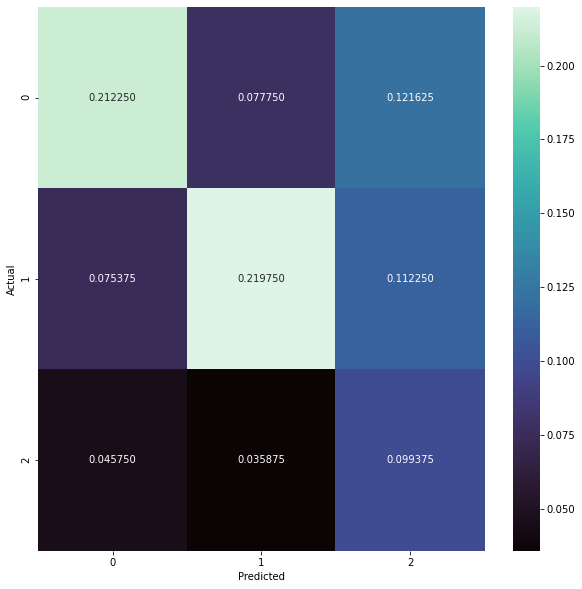

In [8]:
results = model.predict(x_train)
plot_confusionmatrix(results,y_train, normalization = True)

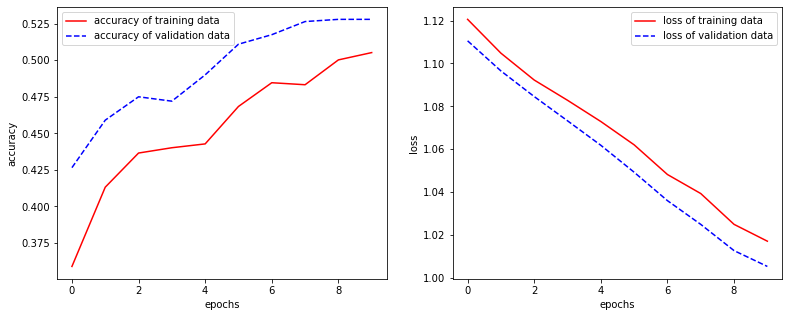

In [9]:
plot_accuracyloss(fit)

## 2 
By reducing the signal-to-noise ratio, namely the
amplitude of the external signal in the data (A) with
respect to the step typical size DX of the jump process,
check where the network (defined in the class) starts to
fail discriminating the categories.


In [10]:
x1,y1,N1 = data_import("ts_L60_Z12_A10_DX50_bias5_N10000")
x2,y2,N2 = data_import("ts_L60_Z12_A500_DX50_bias5_N10000")
x3,y3,N3 = data_import("ts_L60_Z12_A1000_DX50_bias5_N10000")
x4,y4,N4 = data_import("ts_L60_Z12_A10000_DX50_bias5_N10000")


Length of x =  10000
Length of x =  10000
Length of x =  10000
Length of x =  10000


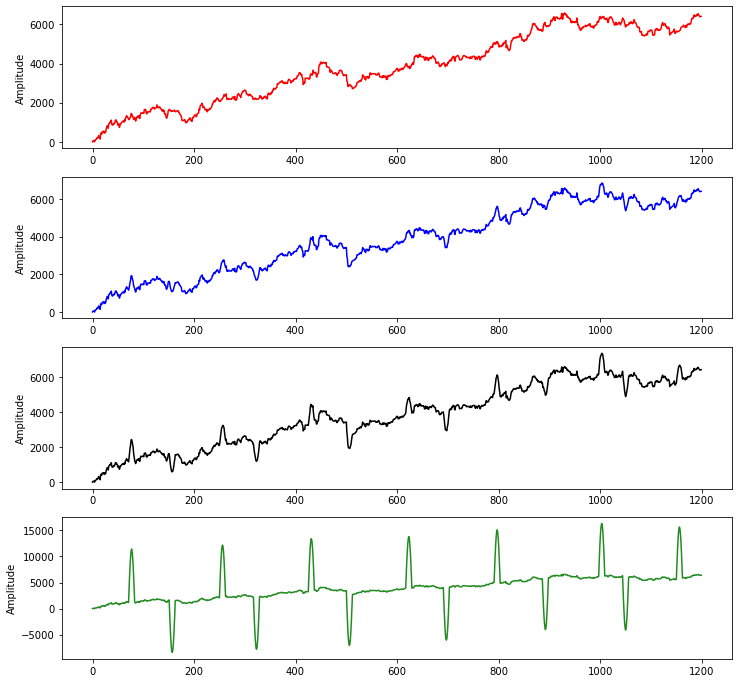

In [11]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, ncols=1, figsize=(12, 12))

xs  = [x1 ,x2 ,x3 ,x4]
axs = [ax1,ax2,ax3,ax4]
colors = ['red','blue','black','forestgreen']

for k in range(len(xs)): 
    for j in range(20):
        axs[k].plot([i for i in range(j*len(xs[k][0]),(len(xs[k][0])+j*len(xs[k][0])))],xs[k][j],color=colors[k])
        axs[k].set_ylabel('Amplitude', fontsize=10)
plt.show()

In [12]:
x1 = data_process(x1,N1)
x2 = data_process(x2,N2)
x3 = data_process(x3,N3)
x4 = data_process(x4,N4)

x1_train, y1_train, x1_val, y1_val, input_shape1 = set_spliting(N1,x1,y1,perc_train = 0.8)
x2_train, y2_train, x2_val, y2_val, input_shape2 = set_spliting(N2,x2,y2,perc_train = 0.8)
x3_train, y3_train, x3_val, y3_val, input_shape3 = set_spliting(N3,x3,y3,perc_train = 0.8)
x4_train, y4_train, x4_val, y4_val, input_shape4 = set_spliting(N4,x4,y4,perc_train = 0.8)

In [13]:
batch_size =250
epochs = 10


fit1 = build_model(conv_lay(input_shape1),layers,3).fit(x1_train,y1_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x1_val,y1_val),
               verbose=2, shuffle=True)

fit2 = build_model(conv_lay(input_shape2),layers,3).fit(x2_train,y2_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x2_val,y2_val),
               verbose=2, shuffle=True)

fit3 = build_model(conv_lay(input_shape3),layers,3).fit(x3_train,y3_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x3_val,y3_val),
               verbose=2, shuffle=True)

fit4 = build_model(conv_lay(input_shape4),layers,3).fit(x4_train,y4_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x4_val,y4_val),
               verbose=2, shuffle=True)

Epoch 1/10
32/32 - 1s - loss: 1.1207 - accuracy: 0.3230 - val_loss: 1.1071 - val_accuracy: 0.3515
Epoch 2/10
32/32 - 1s - loss: 1.1071 - accuracy: 0.3327 - val_loss: 1.1018 - val_accuracy: 0.3350
Epoch 3/10
32/32 - 1s - loss: 1.1018 - accuracy: 0.3405 - val_loss: 1.1000 - val_accuracy: 0.3445
Epoch 4/10
32/32 - 1s - loss: 1.1006 - accuracy: 0.3300 - val_loss: 1.0999 - val_accuracy: 0.3375
Epoch 5/10
32/32 - 1s - loss: 1.1000 - accuracy: 0.3271 - val_loss: 1.0991 - val_accuracy: 0.3390
Epoch 6/10
32/32 - 1s - loss: 1.0992 - accuracy: 0.3300 - val_loss: 1.0990 - val_accuracy: 0.3400
Epoch 7/10
32/32 - 1s - loss: 1.0993 - accuracy: 0.3314 - val_loss: 1.0992 - val_accuracy: 0.3315
Epoch 8/10
32/32 - 1s - loss: 1.0990 - accuracy: 0.3391 - val_loss: 1.0988 - val_accuracy: 0.3305
Epoch 9/10
32/32 - 1s - loss: 1.0992 - accuracy: 0.3309 - val_loss: 1.0991 - val_accuracy: 0.3335
Epoch 10/10
32/32 - 1s - loss: 1.0991 - accuracy: 0.3320 - val_loss: 1.0989 - val_accuracy: 0.3270
Epoch 1/10
32/32 - 

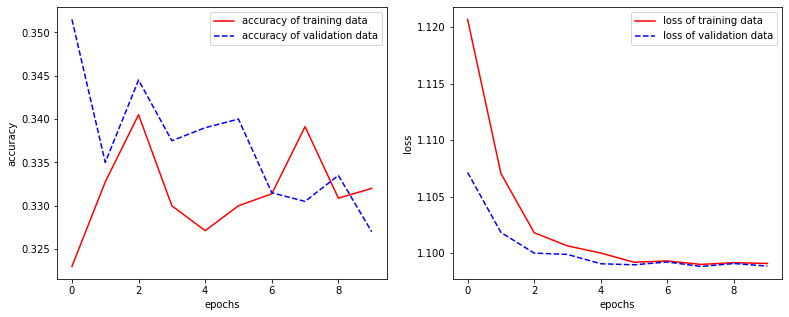

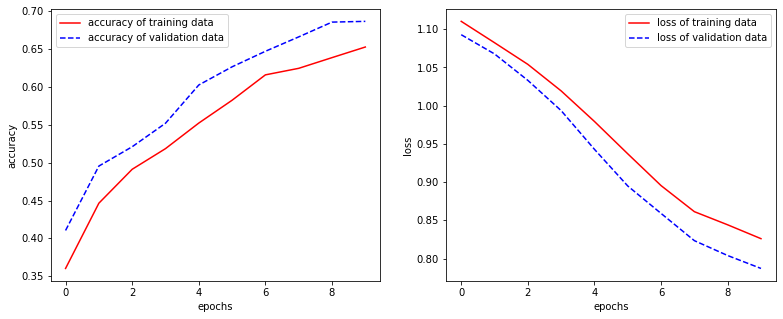

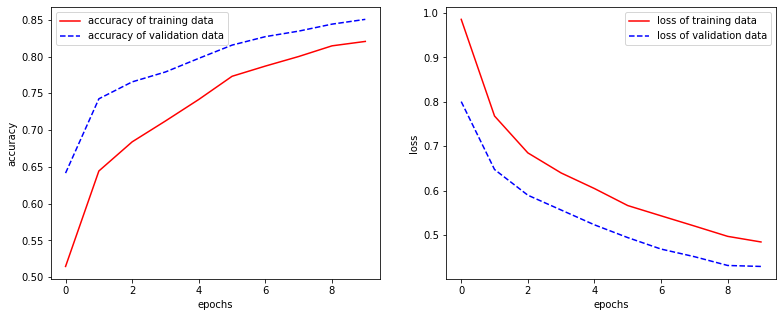

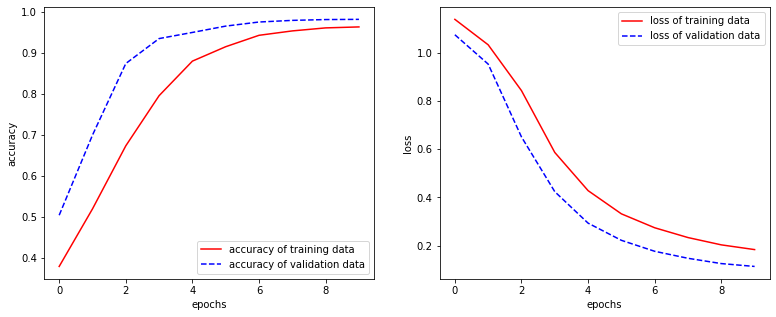

In [14]:
fits = [fit1,fit2,fit3,fit4]
for fit in fits:
    plot_accuracyloss(fit)

3. Try another version where only one convolutional layer is
introduced instead of two, and where any number of
dense layers may be used, with the global constraint of
using a network with at most $600$ trainable parameters.

Is the number of parameters scaling more quickly by adding Dense layers or Conv1D
layers?

In [15]:
# Get the data
str0="ts_comp_N10000"

x, y, N = data_import(str0)
x = data_process(x,N)
x_train, y_train, x_val, y_val, input_shape = set_spliting(N,x,y)
output_size =len(y_train[0])

Length of x =  10000


In [16]:
# Build the model

reg = regularizers.l1(0.01)
#Now we initialize the NN weights
ini = initializers.RandomNormal(mean=0,stddev=0.05)
layers = [AveragePooling1D(5),
          Flatten(),
          Dense(6,activation='relu'),
          Dropout(0.2),
          Dense(12,activation='relu'),
          Dense(9,activation='relu')]

model_1 = build_model(conv_lay(input_shape), layers, output_size)

print(model_1.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 50, 5)             60        
_________________________________________________________________
average_pooling1d_1 (Average (None, 10, 5)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 306       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_8 (Dense)              (None, 9)                

In [17]:
batch_size =250
epochs = 200

fit_1 = model_1.fit(x_train,y_train,
               batch_size=batch_size,
               epochs = epochs,
               validation_data =(x_val,y_val),
               verbose=2, shuffle=True)

Epoch 1/200
32/32 - 1s - loss: 1.1067 - accuracy: 0.3236 - val_loss: 1.1004 - val_accuracy: 0.3570
Epoch 2/200
32/32 - 0s - loss: 1.0996 - accuracy: 0.3289 - val_loss: 1.0989 - val_accuracy: 0.3415
Epoch 3/200
32/32 - 1s - loss: 1.0992 - accuracy: 0.3295 - val_loss: 1.0993 - val_accuracy: 0.3120
Epoch 4/200
32/32 - 1s - loss: 1.0991 - accuracy: 0.3302 - val_loss: 1.0985 - val_accuracy: 0.3465
Epoch 5/200
32/32 - 0s - loss: 1.0988 - accuracy: 0.3296 - val_loss: 1.0987 - val_accuracy: 0.3465
Epoch 6/200
32/32 - 1s - loss: 1.0989 - accuracy: 0.3350 - val_loss: 1.0988 - val_accuracy: 0.3465
Epoch 7/200
32/32 - 1s - loss: 1.0988 - accuracy: 0.3268 - val_loss: 1.0988 - val_accuracy: 0.3465
Epoch 8/200
32/32 - 0s - loss: 1.0988 - accuracy: 0.3256 - val_loss: 1.0987 - val_accuracy: 0.3465
Epoch 9/200
32/32 - 1s - loss: 1.0988 - accuracy: 0.3255 - val_loss: 1.0985 - val_accuracy: 0.3465
Epoch 10/200
32/32 - 0s - loss: 1.0988 - accuracy: 0.3350 - val_loss: 1.0987 - val_accuracy: 0.3465
Epoch 11/

32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 84/200
32/32 - 0s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 85/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 86/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 87/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 88/200
32/32 - 0s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 89/200
32/32 - 0s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 90/200
32/32 - 0s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 91/200
32/32 - 0s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 92/200
32/32 - 0s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 93/200


Epoch 165/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 166/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0985 - val_accuracy: 0.3465
Epoch 167/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0985 - val_accuracy: 0.3465
Epoch 168/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 169/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0987 - val_accuracy: 0.3465
Epoch 170/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 171/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0985 - val_accuracy: 0.3465
Epoch 172/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 173/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accuracy: 0.3465
Epoch 174/200
32/32 - 1s - loss: 1.0987 - accuracy: 0.3350 - val_loss: 1.0986 - val_accurac

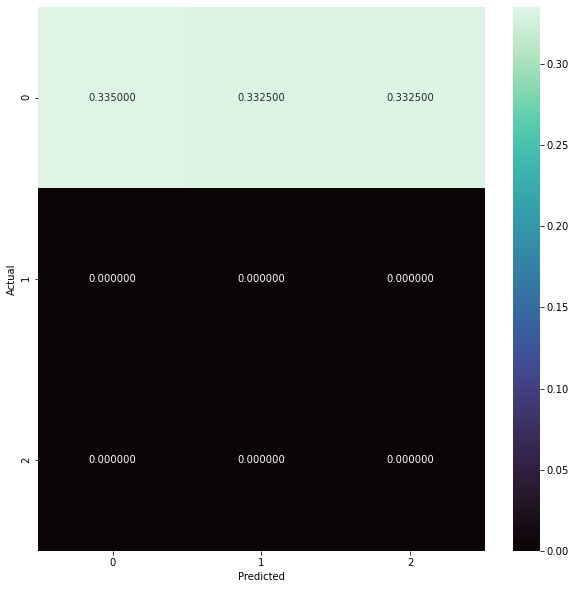

In [18]:
results = model_1.predict(x_train)
plot_confusionmatrix(results,y_train, normalization = True)

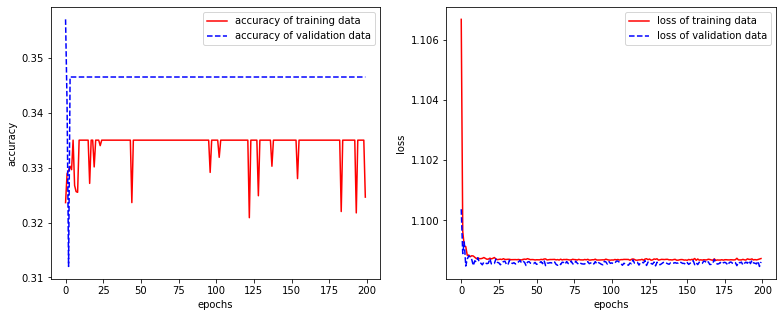

In [19]:
plot_accuracyloss(fit_1)

4. Check if regularization may improve the performances by varying the parameter lambda of
the L1 (LASSO) or of the L2 (Ridge) regularization; see lambda in eqs.(43) and (52) in the
review. There is also a mixed version (l1_l2) that can be tried.

    1. Is there any intermediate value of lambda where the performances of the network are better?

    2. Is there any improvement in the visualization and understanding of the weights in the filters?

Note that the regularization we introduced acts on the w’s, not on the biases. One can also
try the equivalent procedure for biases or for the output of the relu units (see Keras doc.), if
there is any reason for suspecting that it may help. In our case, the logic was to let the
weights of the filters go to zero if not needed, hence that kind of regularization was selected.

In [30]:
from keras.regularizers import l1_l2
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


lam = np.logspace(0,-4,5).tolist()

In [29]:
def reg_conv_lay(l1,l2):
    return Conv1D(filters =5, kernel_size =11, kernel_regularizer = l1_l2(l1 = l1, l2 = l2), kernel_initializer = ini, activation = 'relu', input_shape = input_shape)

def compile_model(l1,l2):

    model = build_model(reg_conv_lay(l1,l2),layers,output_size)
    
    return model

# Using Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=200,
                        batch_size = 250, 
                        verbose=2)

# parameters dictionary
param_grid = dict(l1 = lam,l2=lam)
# Run gridsearch
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

# summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
best_model = grid_result.best_estimator_

PicklingError: Could not pickle the task to send it to the workers.

EXTRA: If there is time, draw the confusion matrix for a CNN model trained with the sequence data of the
exercise 02.

In [ ]:
# Load the datas
ex_fname_x = "DATA/sequences16_x_augmented.csv"
ex_fname_y = "DATA/sequences16_y_augmented.csv"

ex_x = np.loadtxt(ex_fname_x,delimiter=',', dtype=int)
ex_y = np.loadtxt(ex_fname_y,delimiter=',', dtype=int)

print(ex_x)
print(ex_y)

print('Data input shape:', ex_x.shape)
print('Label:',ex_y.shape)

ex_N = ex_y.shape[0]
ex_perc_train = 0.8 # I kept the same train-test ratio as in the lesson
ex_N_train = int(ex_N*ex_perc_train)
ex_N_test = ex_N - ex_N_train

(ex_x_train, ex_y_train) = (ex_x[:ex_N_train],ex_y[:ex_N_train])
(ex_x_test, ex_y_test) = (ex_x[ex_N_train:],ex_y[ex_N_train:])

# Check the fraction of datas equal to one
print(ex_y_train.sum() / ex_N_train)
print(ex_y_test.sum() / ex_N_test)

In [ ]:
# Now we train the best CNN using the data of ex2
ex_batch_size = 250
ex_epochs = 100
fit = best_model.fit(ex_x_train,ex_y_train,
               batch_size=ex_batch_size,
               epochs = ex_epochs,
               validation_data =(ex_x_test,ex_y_test),
               verbose=2, shuffle=True)

In [ ]:
ex_results = best_model.predict(ex_x_train)
plot_confusionmatrix(ex_results,ex_y_train, normalization = True)